In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import time, random
from scipy.optimize import minimize

from qiskit import BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute, IBMQ, Aer
from qiskit.aqua import QuantumInstance, set_qiskit_aqua_logging
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Pauli
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.optimization.applications.ising.common import sample_most_likely, random_graph
from qiskit.providers.aer.noise import NoiseModel

import logging

[[0.  2.  1.  4.  0. ]
 [2.  0.  1.  0.  3.5]
 [1.  1.  0.  2.  1.5]
 [4.  0.  2.  0.  0. ]
 [0.  3.5 1.5 0.  0. ]]


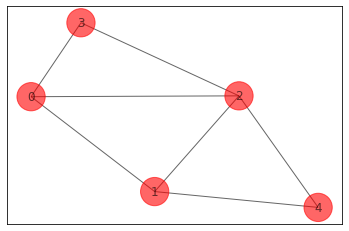

In [2]:
# generate a graph

n = 5
build_random_graph = False

if not build_random_graph:
    G = nx.Graph()
    G.add_nodes_from(np.arange(0, n, 1))
#     E = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0),(4,5,1.0),(2,4,1.0),(3,4,1.0),(0,5,1.0)]
    E = [(0,1,2.0),(0,2,1.0),(0,3,4.0),(1,2,1.0),(2,3,2.0),(4,2,1.5),(4,1,3.5)]
    G.add_weighted_edges_from(E)

    colors = ['r' for node in G.nodes()]
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=800, alpha=0.6, ax=default_axes, pos=pos)

    # build a weight matrix from G
    w = np.zeros([n,n])
    for i, j, data in G.edges.data():
        w[i][j] = data['weight']
        w[j][i] = data['weight']

else: # random graph
    np.random.seed(8123179)
    w = random_graph(n, edge_prob=0.5, weight_range=2, negative_weight=True)
    qubitOp, offset = max_cut.get_operator(w)
print(w)

#### Convert adjacency matrix to Hamiltonians

Example listed [here](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747). For a given edge, the two nodes being connected will be represented with Z and others X. 

In [3]:
from qiskit.quantum_info import Pauli
ixzy = Pauli([True, True, False, False], [True, False, True, False])
print(ixzy)   # How we define gates

IXZY


In [4]:
def adj2paulis(adjM):
    n = adjM.shape[0]  # num nodes
    paulis = []
    offset = 0
    for i in range(n):
        for j in range(i):
            if adjM[i, j] != 0:
                x_p = np.zeros(n, dtype=np.bool)  
                z_p = np.zeros(n, dtype=np.bool)
                z_p[i], z_p[j] = True, True  
                paulis.append([0.5 * adjM[i,j], Pauli(z_p, x_p)])
                offset -= 0.5 * adjM[i, j]
    return WeightedPauliOperator(paulis=paulis), offset

In [5]:
wpo, offset = adj2paulis(w)
print(wpo.print_details())
print("offset: ", offset)
print(wpo.to_dict())

IIIZZ	(1+0j)
IIZIZ	(0.5+0j)
IIZZI	(0.5+0j)
IZIIZ	(2+0j)
IZZII	(1+0j)
ZIIZI	(1.75+0j)
ZIZII	(0.75+0j)

offset:  -7.5
{'paulis': [{'label': 'IIIZZ', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'IIZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'IIZZI', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'IZIIZ', 'coeff': {'real': 2.0, 'imag': 0.0}}, {'label': 'IZZII', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'ZIIZI', 'coeff': {'real': 1.75, 'imag': 0.0}}, {'label': 'ZIZII', 'coeff': {'real': 0.75, 'imag': 0.0}}]}


In [6]:
def weightedPaulisToPaulis(wpo):
    """
    @param wpo: Weighted PauliOperator
    @return ps: Pauli Operator list
        [(label, coeff, pauli object), ...]
        will use the pauli object to instruction for circuit building
    """
    ps = []
    wpos = wpo.to_dict()['paulis']
    for d in wpos:
        label, coeff = d['label'], d['coeff']['real']
        pauli = Pauli(label=label)
        ps.append((label, coeff, pauli))
    return ps

In [7]:
wpo.to_dict()['paulis'][0]
Pauli(label='IZIZ')

Pauli(z=[True, False, True, False], x=[False, False, False, False])

In [8]:
wpo.to_dict()

{'paulis': [{'label': 'IIIZZ', 'coeff': {'real': 1.0, 'imag': 0.0}},
  {'label': 'IIZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IIZZI', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IZIIZ', 'coeff': {'real': 2.0, 'imag': 0.0}},
  {'label': 'IZZII', 'coeff': {'real': 1.0, 'imag': 0.0}},
  {'label': 'ZIIZI', 'coeff': {'real': 1.75, 'imag': 0.0}},
  {'label': 'ZIZII', 'coeff': {'real': 0.75, 'imag': 0.0}}]}

In [9]:
weightedPaulisToPaulis(wpo)

[('IIIZZ',
  1.0,
  Pauli(z=[True, True, False, False, False], x=[False, False, False, False, False])),
 ('IIZIZ',
  0.5,
  Pauli(z=[True, False, True, False, False], x=[False, False, False, False, False])),
 ('IIZZI',
  0.5,
  Pauli(z=[False, True, True, False, False], x=[False, False, False, False, False])),
 ('IZIIZ',
  2.0,
  Pauli(z=[True, False, False, True, False], x=[False, False, False, False, False])),
 ('IZZII',
  1.0,
  Pauli(z=[False, False, True, True, False], x=[False, False, False, False, False])),
 ('ZIIZI',
  1.75,
  Pauli(z=[False, True, False, False, True], x=[False, False, False, False, False])),
 ('ZIZII',
  0.75,
  Pauli(z=[False, False, True, False, True], x=[False, False, False, False, False]))]

#### Exact Answer
---

In [10]:
# Exact Eigensolver
ee = ExactEigensolver(wpo, k=1)
result = ee.run()
print("the ground state energy: ", result["energy"])
print("exact result: ", -1*(result["energy"]+offset))

the ground state energy:  -5.0
exact result:  12.5


/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


case = [0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0] cost = 7.0
case = [0, 1, 0, 0, 0] cost = 6.5
case = [1, 1, 0, 0, 0] cost = 9.5
case = [0, 0, 1, 0, 0] cost = 5.5
case = [1, 0, 1, 0, 0] cost = 10.5
case = [0, 1, 1, 0, 0] cost = 10.0
case = [1, 1, 1, 0, 0] cost = 11.0
case = [0, 0, 0, 1, 0] cost = 6.0
case = [1, 0, 0, 1, 0] cost = 5.0
case = [0, 1, 0, 1, 0] cost = 12.5
case = [1, 1, 0, 1, 0] cost = 7.5
case = [0, 0, 1, 1, 0] cost = 7.5
case = [1, 0, 1, 1, 0] cost = 4.5
case = [0, 1, 1, 1, 0] cost = 12.0
case = [1, 1, 1, 1, 0] cost = 5.0
case = [0, 0, 0, 0, 1] cost = 5.0
case = [1, 0, 0, 0, 1] cost = 12.0
case = [0, 1, 0, 0, 1] cost = 4.5
case = [1, 1, 0, 0, 1] cost = 7.5
case = [0, 0, 1, 0, 1] cost = 7.5
case = [1, 0, 1, 0, 1] cost = 12.5
case = [0, 1, 1, 0, 1] cost = 5.0
case = [1, 1, 1, 0, 1] cost = 6.0
case = [0, 0, 0, 1, 1] cost = 11.0
case = [1, 0, 0, 1, 1] cost = 10.0
case = [0, 1, 0, 1, 1] cost = 10.5
case = [1, 1, 0, 1, 1] cost = 5.5
case = [0, 0, 1, 1, 1] cost = 9.5
case

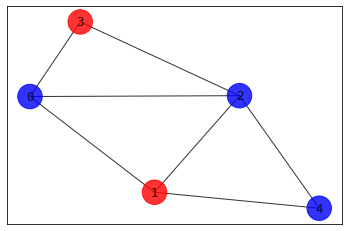

In [11]:
# Brute Force
# brute force
import time
start = time.time()
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute <= cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute) + ' time taken: {:.5f}s'.format(time.time()-start))

#### Approximator

In [12]:
def prep_ansantz(qc, params):
    # requires 2*n params
    q = qc.qregs[0]  # take the quantum register out
    n = q.size
    try:
        assert(len(params) == 2*n)
    except:
        raise ValueError("Not enough parameters, need ", len(params))
    for i in range(n):
        qc.rx(params[2*i], q[i])
        qc.ry(params[2*i+1], q[i])
        
    for i in range(n):
        if i < n-1:
            qc.cx(q[i], q[i+1])
    return qc

def prep_ansantz2(qc, params):
    # requires 6*n params
    q = qc.qregs[0]  # take the quantum register out
    n = q.size
    try:
        assert(len(params) == 6*n)
    except:
        raise ValueError("Not enough parameters, need ", len(params))
    for i in range(n):
        qc.rx(params[2*i], q[i])
        qc.ry(params[2*i+1], q[i])
            
    qc.barrier()
    for i in range(n):
        if i < n-1:
            print(q[i], q[i+1])
            qc.cx(q[i], q[i+1])
            qc.rx(params[2*i+3], q[i+1])
            qc.ry(params[2*i+4], q[i+1])
    
    qc.barrier()
    for i in range(n):
        qc.rx(params[2*i+5], q[i])
        qc.ry(params[2*i+6], q[i])
    return qc


def prep_ansantz3(qc, params, layers=2):
    # requires 12*params
    q = qc.qregs[0]  # take the quantum register out
    n = q.size
    try:
        assert(len(params) == 12*n)
    except:
        raise ValueError("Not enough parameters, need ", len(params))
        
    for i in range(n):
        qc.u3(params[2*i], params[2*i+1], params[2*i+2], q[i])

    qc.barrier()
    for i in range(n):
        if i < n-1:
            qc.cx(q[i], q[i+1])
            qc.u3(params[2*i+3], params[2*i+4], params[2*i+5], q[i+1])
    
    qc.barrier()
    for i in range(n):
        qc.u3(params[2*i+6], params[2*i+7], params[2*i+8], q[i])

    qc.barrier()
    for i in range(n):
        if i < n-1:
            qc.cx(q[i], q[i+1])
            qc.u3(params[2*i+9], params[2*i+10], params[2*i+11], q[i+1])

    qc.barrier()
    return qc

In [13]:
# Im gonna go for a custom one, but may need to use something like RY from
# from qiskit.aqua.components.variational_forms import RY

def vqe_circuit(n, params, pauli_label):
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)
    qc = QuantumCircuit(qr, cr)
    qc = prep_ansantz3(qc, params)
#     qc = prep_ansantz2(qc, params)
    qc.barrier()
    # add the pauli

    for i, gate in enumerate(pauli_label):
        if gate == 'Z':
            qc.z(qr[i])
    # add measurements?
    
    qc.barrier()
    for i in range(n):
        qc.measure(qr[i], cr[i])
    return qc

def get_exp(counts: dict, pauli_label: str):
    """ to get expected value 
    @param counts: dictionary of measurements
    @param pauli label: str - used as a mask
        - when computing (-1)**sum([...]) to determine the eigen value
          only consider the measurements resulting from X, Y, Z gates, not I
    """
    exp, N = 0, 0
    for m, c in counts.items():
        mask = np.array(list(pauli_label)) != 'I'
        m_ = np.array(list(m))[mask]        
        eigen = (-1)**sum([int(i) for i in m_])  # this determine the eigen value of the vector m
        exp += eigen*c
        N += c
    return exp/N

def vqe_module(params, pauli_label, n_shots=1000, noise=None):
    """
    returns expected value of current iteration and the quantum circuit
    """
    n = len(params) // 12
    qc = vqe_circuit(n, params, pauli_label)
    
    if noise is None:
        # initialize backend
        results = execute(qc, Aer.get_backend('qasm_simulator'), 
                          shots=n_shots).result()
    
    else: 
        # backend is the noisy package containing 
        # noise_model, coupling_map, basis_gates
        noise_model, coupling_map, basis_gates = noise
        results = execute(qc, Aer.get_backend('qasm_simulator'),
                          coupling_map=coupling_map, 
                          basis_gates=basis_gates, 
                          noise_model=noise_model).result()
    
    counts = results.get_counts()
    expected_value = get_exp(counts, pauli_label)
    return expected_value, qc

def get_eigenvectors(params, n_shots=1000, noise=None):
    n = len(params) // 12
    qc = vqe_circuit(n, params, "I"*n)
    if noise is None:
        # initialize backend
        results = execute(qc, Aer.get_backend('qasm_simulator'), 
                          shots=n_shots).result()
    
    else: 
        # backend is the noisy package containing 
        # noise_model, coupling_map, basis_gates
        noise_model, coupling_map, basis_gates = noise
        results = execute(qc, Aer.get_backend('qasm_simulator'),
                      coupling_map=coupling_map,
                      basis_gates=basis_gates,
                      noise_model=noise_model).result()
    
    counts = results.get_counts()
    return counts

def vqe(wpo: WeightedPauliOperator, params: list, n_shots:int=1000, noise=None):
    
    # paulis: [(label, ceof, pauli), ...]
    paulis = weightedPaulisToPaulis(wpo) 
    exp_sum = 0
    for label, coef, _ in paulis:
        exp_sum += coef*vqe_module(params, label, n_shots, noise=noise)[0]
    return exp_sum

def get_noise_model():
    provider = IBMQ.load_account()
    backend = provider.get_backend('ibmq_vigo')
    noise_model = NoiseModel.from_backend(backend)
    coupling_map = backend.configuration().coupling_map
    basis_gates = noise_model.basis_gates
    return noise_model, coupling_map, basis_gates

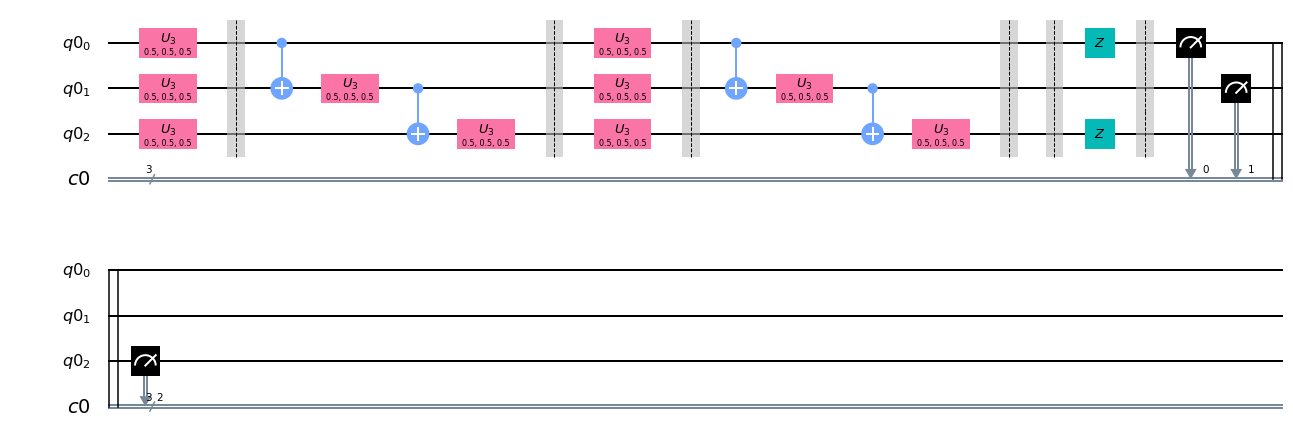

In [14]:
exp, qc = vqe_module([0.5]*3*12, 'ZIZ')
qc.draw(output="mpl")

### Experiment

In [15]:
wpo, offset = adj2paulis(w)

In [16]:
from scipy.optimize import minimize

# optimize
params = np.array([random.random() for _ in range(n*12)])
tolerance = 1e-6
n_shots = 1000
vqe_wrapper = lambda x: vqe(wpo, params=x, n_shots=n_shots)
%time vqe_result = minimize(vqe_wrapper, params, method="Powell", tol=tolerance)

CPU times: user 13min 14s, sys: 29 s, total: 13min 43s
Wall time: 15min 38s


In [17]:
vqe_result.x

array([ 3.16645094e+00,  5.93869901e+00,  3.16276369e-01,  2.94186019e-01,
        3.68794144e-01,  3.78414436e-01,  3.23404049e-01,  2.84937045e-01,
        3.42219445e-01,  1.78010749e-01, -1.28948679e-02,  5.90596625e-02,
        4.77723756e-01,  4.11030877e-01, -6.24240880e-01,  4.44349528e-01,
        3.48488909e+00,  3.32323032e-02,  2.70745898e+00,  4.13926165e+00,
        3.64753686e+00,  3.74044436e+00,  1.22393912e+01,  1.44945783e+00,
       -1.75272451e+00,  2.30404631e+00, -1.10783737e+00,  3.47780382e+00,
        6.86059980e+00,  4.68485024e+00,  8.74817627e+00,  6.42876173e-01,
        1.00722242e+01,  4.31087866e+00,  9.09755182e+00,  6.91132711e+00,
        2.69298735e+00,  5.47179890e+00,  4.16977746e+00,  3.98260324e+00,
        5.20856735e+00,  9.06465609e+00, -4.64803711e+01,  7.14005786e+00,
        7.02695433e+00,  9.45414726e+00,  1.65158786e+00,  1.85343228e+01,
        1.41601781e+01,  8.25135867e+00,  1.30154283e+00, -2.45889585e+01,
        5.92804109e+00,  

In [18]:
print("the ground state energy: ", result["energy"])
print("vqe ground state energy: ", vqe_result.fun)
print("vqe result: ", -1*(vqe_result.fun + offset))

the ground state energy:  -5.0
vqe ground state energy:  -4.933
vqe result:  12.433


/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


#### Get Eigen-vectors

In [19]:
counts = get_eigenvectors(vqe_result.x)
eigen_vec = sample_most_likely(counts)
print(eigen_vec)

[1 0 1 0 1]


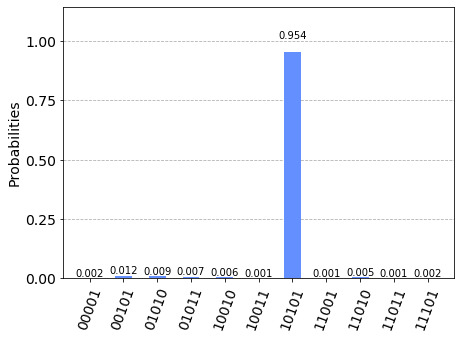

In [20]:
plot_histogram(counts)

#### More Experiments

In [23]:
wpo, offset = adj2paulis(w)

params = np.array([random.random() for _ in range(n*12)])
tolerance = 1e-6
n_shots = 10000
vqe_wrapper = lambda x: vqe(wpo, params=x, n_shots=n_shots)
%time vqe_result = minimize(vqe_wrapper, params, method="Powell", tol=tolerance)
print(vqe_result.x)
counts = get_eigenvectors(vqe_result.x)
eigen_vec = sample_most_likely(counts)

CPU times: user 41min 12s, sys: 37 s, total: 41min 49s
Wall time: 43min 24s
[ 3.13242719e+00  5.98472919e-01  1.26368638e-01  1.47174663e-01
  4.75440822e-01  4.80217911e-01  2.08232963e-01  2.39666273e-01
  3.44050251e-02  2.30873552e-02  1.26708446e-01 -1.30978792e-01
  3.72550313e-01  3.15125917e-01 -3.51408093e-01  2.99742031e-01
  5.20997986e+00 -2.21571518e-01  6.08430182e-01  3.34661222e+00
  1.15235161e+01 -3.96880968e+01  4.68210811e+00  2.97818182e+00
  2.88973710e+00  1.60452697e+00  1.40953079e+01  1.63086455e+00
 -2.20481936e+00  9.66068101e+00  8.81498770e+00  9.33840710e+00
  7.44335984e+00  7.85248797e+00  6.73453656e+00  6.19008678e+00
  2.76484558e+00 -2.69608758e-01  8.70187346e+00  2.88686707e+00
  4.96864049e-01 -9.16824903e+00  7.65885481e+00  7.98503829e+00
  1.43926536e+00  8.93483230e+00  4.14156204e+00  3.25609175e+00
  2.62800008e+00  1.46147384e+00  1.47579774e+01  9.70796955e+00
  2.99291067e+00  8.87644421e+00  6.73292602e+00 -2.98064207e-01
  1.27769655e+

the ground state energy:  -5.0
vqe ground state energy:  -4.95595
vqe result - Eigen value:  12.45595
           - Eigen vector:  [1 0 1 0 1]


/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


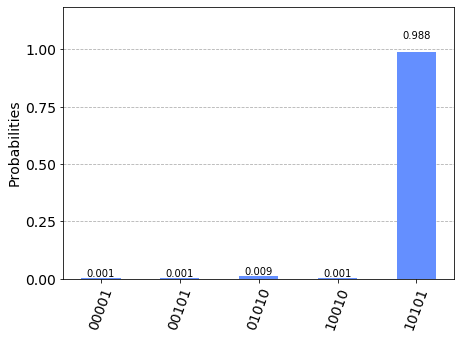

In [24]:
print("the ground state energy: ", result["energy"])
print("vqe ground state energy: ", vqe_result.fun)
print("vqe result - Eigen value: ", -1*(vqe_result.fun + offset))
print("           - Eigen vector: ", eigen_vec)
plot_histogram(counts)

#### With Noise

In [21]:
# on noisy model
wpo, offset = adj2paulis(w)
params = np.array([random.random() for _ in range(n*12)])
tolerance = 1e-6
n_shots = 1000
noise = get_noise_model()
vqe_wrapper = lambda x: vqe(wpo, params=x, n_shots=n_shots, noise=noise)
%time vqe_result = minimize(vqe_wrapper, params, method="Powell", tol=tolerance)
print(vqe_result.x)
counts = get_eigenvectors(vqe_result.x)
eigen_vec = sample_most_likely(counts)

CPU times: user 37min 5s, sys: 2min 33s, total: 39min 38s
Wall time: 39min 59s
[ 3.21669453e+00  1.14411119e+00  5.22027769e-01  4.99304277e-01
  7.27492702e-01  3.98216107e-01 -1.06834954e-01  1.32216043e-01
  2.57816173e-01  4.52743803e-01 -6.56053109e-02  2.28557407e-01
  6.30084721e-01  4.15265422e-01 -2.89002946e-01  3.10477504e-02
 -3.70687437e-01  3.00695066e+00 -9.25731667e-01  8.17230404e+00
  2.05980306e+00  2.99870299e+00  1.80285407e+00  1.26590404e+00
  5.05972856e+00  2.72817300e+00  1.65275995e+00  2.03972558e+00
 -1.44140106e+00  4.26084573e-01  5.50197805e+00  2.40352990e-01
  4.91512470e+00  3.33461595e+01  3.72256529e+00 -3.20653866e+00
  2.38634529e+00  2.87262297e+00  3.40644765e+00  4.52767622e+00
  3.14807450e-01  3.47591387e+00  1.18735587e+00  4.89455492e+00
  1.32546236e-01  4.21865907e+00  1.69662796e+00  1.36128265e+00
  3.04255107e+00  4.92860801e+00  7.43647589e-01  2.21731885e+00
 -5.96471882e-01  3.11797264e+00  7.19182868e+00 -6.86112637e-01
 -3.4547231

the ground state energy:  -5.0
vqe ground state energy:  -3.6513671875
vqe result - Eigen value:  11.1513671875
           - Eigen vector:  [1 0 1 0 1]


/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)


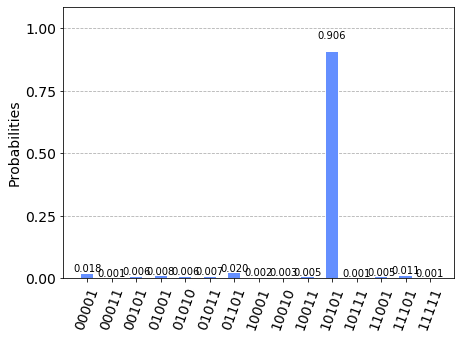

In [22]:
print("the ground state energy: ", result["energy"])
print("vqe ground state energy: ", vqe_result.fun)
print("vqe result - Eigen value: ", -1*(vqe_result.fun + offset))
print("           - Eigen vector: ", eigen_vec)
plot_histogram(counts)